In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [26]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_no_zeroes.csv", index_col=0)
    genres.columns = range(genres.shape[1])
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    curr = genres_index['genre_index']
    late = genres[0].unique().tolist()
    update_genres = {late[i]:curr[i] for i in range(len(curr))}
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    genres.columns = range(genres.shape[1])
    genres[0]=genres[0].map(update_genres)
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    #generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    # print(genres)
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    # test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(16))
    split.index = genres.index
    genres = split
    return data_x, genres

In [27]:
data, labels = prepareData()
#data = data.reshape(-1, 1, 518)

x_train, x_rest, y_train, y_rest = train_test_split(data, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

In [28]:
CNN = models.Sequential()
#CNN.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(518,1),padding='SAME'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.3))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.3))
# CNN.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
# CNN.add(layers.MaxPooling1D(3))
# CNN.add(layers.Dropout(0.25))
# CNN.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
# CNN.add(layers.MaxPooling1D(3))
# CNN.add(layers.Dropout(0.25))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(256, activation='relu'))
CNN.add(layers.Dense(256, activation='relu'))
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))

In [29]:
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 518, 64)           256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 172, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 172, 64)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 170, 128)          24704     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 56, 128)          0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 56, 128)          

In [30]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=10,verbose=1),tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=10,verbose=1)]
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [31]:
training = CNN.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size=389, callbacks=callback)

Epoch 1/100
102/102 [==============================] - 30s 292ms/step - loss: 1.7120 - accuracy: 0.4587 - val_loss: 1.3753 - val_accuracy: 0.5835
Epoch 2/100
102/102 [==============================] - 30s 298ms/step - loss: 1.3272 - accuracy: 0.5879 - val_loss: 1.2870 - val_accuracy: 0.6054
Epoch 3/100
102/102 [==============================] - 31s 300ms/step - loss: 1.2174 - accuracy: 0.6173 - val_loss: 1.1902 - val_accuracy: 0.6280
Epoch 4/100
102/102 [==============================] - 31s 304ms/step - loss: 1.1696 - accuracy: 0.6268 - val_loss: 1.1674 - val_accuracy: 0.6383
Epoch 5/100
102/102 [==============================] - 33s 319ms/step - loss: 1.1120 - accuracy: 0.6432 - val_loss: 1.1457 - val_accuracy: 0.6381
Epoch 6/100
102/102 [==============================] - 32s 315ms/step - loss: 1.0757 - accuracy: 0.6542 - val_loss: 1.1141 - val_accuracy: 0.6476
Epoch 7/100
102/102 [==============================] - 33s 325ms/step - loss: 1.0413 - accuracy: 0.6660 - val_loss: 1.0661 -

In [32]:
x_train.shape

(39678, 518)

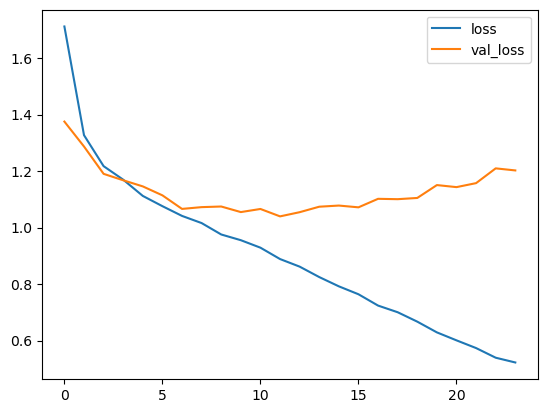

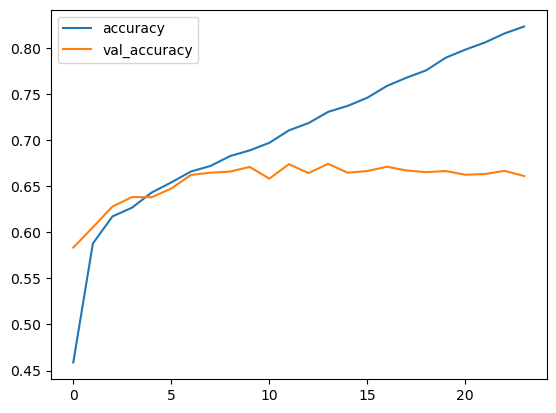

In [33]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();# The semicolon prevents certain matplotlib items from being printed.

In [34]:
print(training.history)

{'loss': [1.7119520902633667, 1.3271901607513428, 1.2174326181411743, 1.1695594787597656, 1.112040400505066, 1.0757324695587158, 1.0412707328796387, 1.0159016847610474, 0.9754846096038818, 0.9552721381187439, 0.9287660121917725, 0.8885164260864258, 0.8616703152656555, 0.8247121572494507, 0.7918859720230103, 0.7638547420501709, 0.7237634658813477, 0.7002166509628296, 0.6668840050697327, 0.6288976669311523, 0.6006808876991272, 0.5733253955841064, 0.5392109155654907, 0.5223374962806702], 'accuracy': [0.4587428867816925, 0.5878824591636658, 0.6172690391540527, 0.6268209218978882, 0.6432027816772461, 0.654191255569458, 0.665960967540741, 0.6720600724220276, 0.6827713251113892, 0.688946008682251, 0.6971369385719299, 0.7106961011886597, 0.7185593843460083, 0.7307323813438416, 0.7372851371765137, 0.7461061477661133, 0.7588840126991272, 0.767881453037262, 0.7757951617240906, 0.7895559072494507, 0.7983013391494751, 0.8060638308525085, 0.8158929347991943, 0.8234285712242126], 'val_loss': [1.37525

In [35]:
y_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
track_id,,,,,,,,,,,,,,,,
44224,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116195,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55633,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53713,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130963,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124317,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_loss, test_acc = CNN.evaluate(x_test,y_test)

155/155 [==============================] - 2s 13ms/step - loss: 1.1562 - accuracy: 0.6685


In [37]:
test_acc

0.6685484051704407